<a href="https://colab.research.google.com/github/sana-kabbani/PD_Classification/blob/main/swin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models.swin_transformer import swin_s
import torch.nn.functional as F
from torchvision.utils import make_grid




print(torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

2.3.0+cu121
cuda:0


In [ ]:
path = "/content/drive/MyDrive/Data/Frames/imgs"


data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)


#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])


print("-------------Fetch files into a data frame-----------")
print(df)
print("-------------Path to an image file------------------")
print(df.loc[175]['imgpath'])
print("-----------Number of images per category--------------")
print(df.labels.value_counts())

-------------Fetch files into a data frame-----------
                                                imgpath               labels  \
0     /content/drive/MyDrive/Data/Frames/imgs/non_pa...  non_parkinson_faces   
1     /content/drive/MyDrive/Data/Frames/imgs/non_pa...  non_parkinson_faces   
2     /content/drive/MyDrive/Data/Frames/imgs/non_pa...  non_parkinson_faces   
3     /content/drive/MyDrive/Data/Frames/imgs/non_pa...  non_parkinson_faces   
4     /content/drive/MyDrive/Data/Frames/imgs/non_pa...  non_parkinson_faces   
...                                                 ...                  ...   
2634  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   
2635  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   
2636  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   
2637  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   
2638  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parki

In [ ]:
train_df, valid_df = train_test_split(df,  train_size= 0.80 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print("#############Train Split###################")
print(train_df.head(5))
print(train_df.shape)
print("#############Test Split###################")
print(valid_df.head(5))
print(valid_df.shape)

#############Train Split###################
                                             imgpath               labels  \
0  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   
1  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   
2  /content/drive/MyDrive/Data/Frames/imgs/non_pa...  non_parkinson_faces   
3  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   
4  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   

   encoded_labels  
0               1  
1               1  
2               0  
3               1  
4               1  
(2111, 3)
#############Test Split###################
                                             imgpath               labels  \
0  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   
1  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   
2  /content/drive/MyDrive/Data/Frames/imgs/parkin...      parkinson_faces   
3  /content/

In [ ]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),

}

In [ ]:
class flower_Dataset(Dataset):
    def __init__(self, img_data, transform=None):
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = self.img_data.loc[index]['imgpath']
        imge = Image.open(img_name).convert('RGB')

        # Check the number of channels in the image
        if imge.mode != 'RGB':
            # If the image doesn't have RGB mode, skip it
            print(f"Skipping image {img_name} because it does not have RGB mode.")
            return self.__getitem__((index + 1) % len(self))  # Skip this image by recursively calling __getitem__ with the next index

        # Resize the image
        image = imge.resize((224, 224))

        if self.transform is not None:
            image = self.transform(image)

        label = torch.tensor(self.img_data.loc[index]['encoded_labels'])
        return image, label

# Create datasets
training_data = flower_Dataset(train_df, image_transforms['train'])
validation_data = flower_Dataset(valid_df, image_transforms['valid'])

In [ ]:
train_batch_size = 200
val_batch_size = 100

train_dataloader = DataLoader(training_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(validation_data, batch_size=val_batch_size , shuffle=True)

print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset) , train_batch_size , len(train_dataloader)))
print(">> Number of Validiation Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset) , val_batch_size , len(test_dataloader)))
onebatch = iter(train_dataloader)
train_features, train_labels = next(onebatch)
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")

>> Number of Train Data : 2111 -- Batch Size : 200 -- Number of Batch : 11 
>> Number of Validiation Data : 528 -- Batch Size : 100 -- Number of Batch : 6 
----------Batch Shape--------
Feature batch shape: torch.Size([200, 3, 224, 224])
----------Labels Shape--------
Labels batch shape: torch.Size([200])


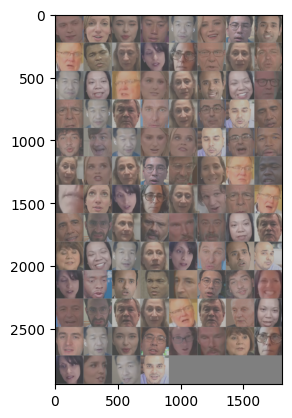

In [ ]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
def imeshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0,2)
    plt.imshow(inp)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = make_grid(inputs)
imeshow(out)

In [ ]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)

Using cache found in /root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth
100%|██████████| 109M/109M [00:00<00:00, 219MB/s] 


In [ ]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 5)
)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

print("okey")

okey


In [ ]:
def train_model(model, optimizer, criterion , data_loader, device):

    model.train()
    running_loss = 0.0
    correct = 0


    for i, data in enumerate(data_loader):
        inputs , labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item() * inputs.size(0)


    avg_train_loss = running_loss / len(data_loader.dataset)
    avg_train_acc = ( correct / len(data_loader.dataset) ) * 100
    print(">>> Train loss {} ---- Accuracy Train {} ".format(avg_train_loss, avg_train_acc))


    return avg_train_loss , avg_train_acc

In [ ]:
# def test_model(model, criterion , data_loader, device):

#     model.eval()

#     val_loss = 0.0
#     correct = 0
#     with torch.no_grad():
#         for i, data in enumerate(data_loader):

#             inputs , labels = data
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs.data, 1)
#             correct += (predicted == labels).sum().item()

#         avg_val_acc = ( correct / len(data_loader.dataset) ) * 100
#         avg_val_loss = val_loss / len(data_loader.dataset)

#         print(">>> Validation loss {} ---- Validation Accuracy {} ".format(avg_val_loss, avg_val_acc))

#     return avg_val_loss , avg_val_acc
from sklearn.metrics import precision_score, recall_score

def test_model(model, criterion, data_loader, device):
    model.eval()

    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    avg_val_acc = (correct / len(data_loader.dataset)) * 100
    avg_val_loss = val_loss / len(data_loader.dataset)

    # Calculate precision and recall
    all_labels = labels.cpu().numpy()
    all_predictions = predicted.cpu().numpy()
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')

    # Print scores
    print(">>> Validation loss {:.4f} ---- Validation Accuracy {:.2f}%".format(avg_val_loss, avg_val_acc))
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    return avg_val_loss , avg_val_acc


In [ ]:
num_epochs = 5
history = {  "train_loss" : [] ,  "train_acc" : [] ,  "val_loss" : [] ,  "val_acc" : [] }

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    T_loss , T_acc = train_model(model , optimizer , criterion, train_dataloader , device)
    V_loss , V_acc = test_model(model , criterion , test_dataloader, device)

    history["train_loss"].append(T_loss)
    history["train_acc"].append(T_acc)
    history["val_loss"].append(V_loss)
    history["val_acc"].append(V_acc)

------------------ Training Epoch 1 ------------------
>>> Train loss 0.7699787157906677 ---- Accuracy Train 60.445286594031266 
>>> Validation loss 0.4489 ---- Validation Accuracy 79.55%
Recall: 0.8571
Precision: 0.8571
------------------ Training Epoch 2 ------------------
>>> Train loss 0.444560417895744 ---- Accuracy Train 79.63050686878258 
>>> Validation loss 0.3279 ---- Validation Accuracy 88.26%
Recall: 0.8571
Precision: 0.8571
------------------ Training Epoch 3 ------------------
>>> Train loss 0.3477142797381547 ---- Accuracy Train 85.88346755092373 
>>> Validation loss 0.2850 ---- Validation Accuracy 88.64%
Recall: 0.8929
Precision: 0.9118
------------------ Training Epoch 4 ------------------
>>> Train loss 0.2879049401749711 ---- Accuracy Train 88.25201326385599 
>>> Validation loss 0.2188 ---- Validation Accuracy 91.86%
Recall: 1.0000
Precision: 1.0000
------------------ Training Epoch 5 ------------------
>>> Train loss 0.253557361637682 ---- Accuracy Train 89.862624348

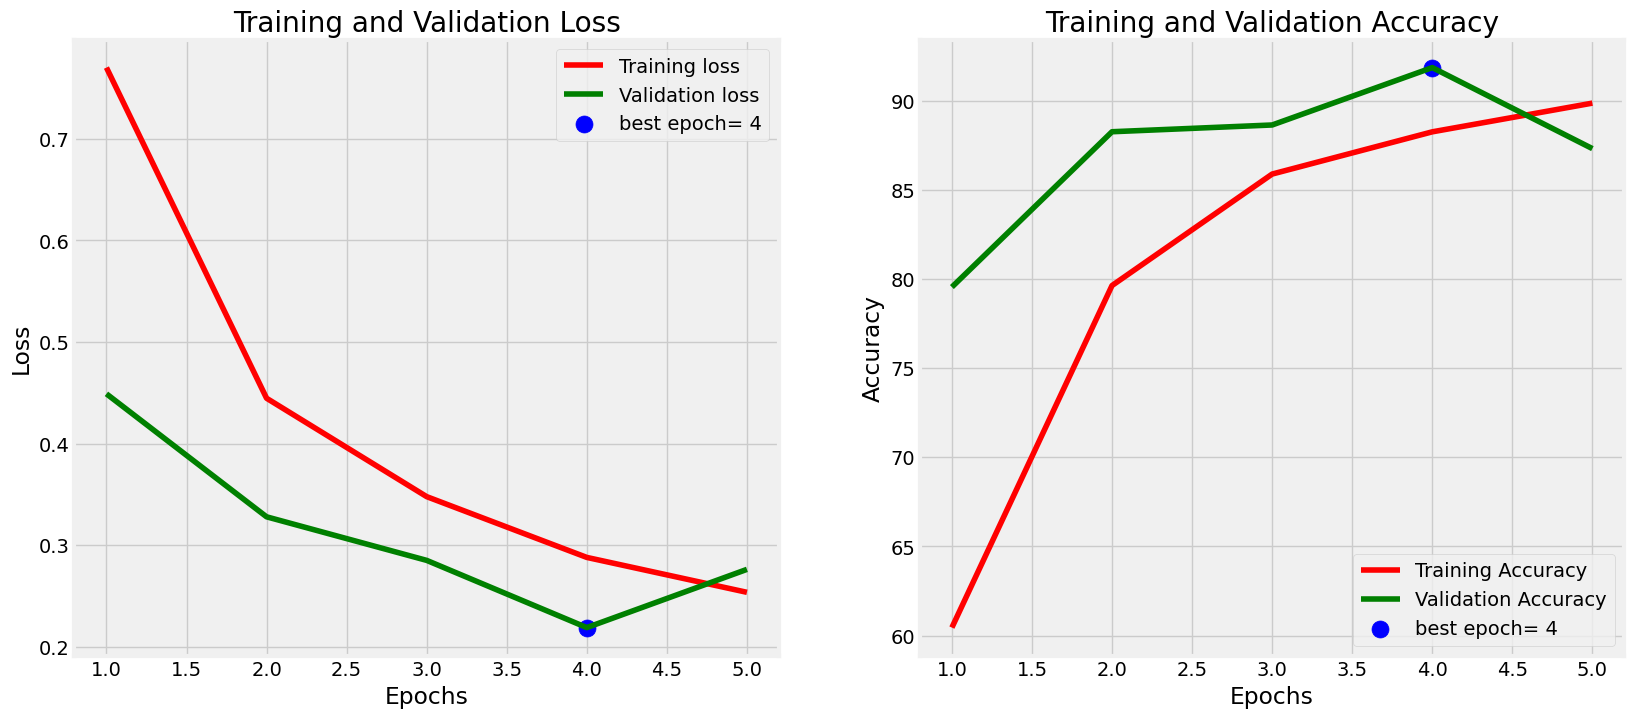

In [ ]:
# Define needed variables
tr_acc = history["train_acc"]
tr_loss = history["train_loss"]
val_acc = history["val_acc"]
val_loss = history["val_loss"]


index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
